# Bear classifier using fastai library and ResNet18

The final goal of this project is to deploy the application to Hugging Face and have a first interface iteration.

- [Hugging Face demo](https://huggingface.co/spaces/dmosc/bear-classifier)

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import Path, L
from fastai.vision.all import Image, download_images, resize_images, verify_images, get_image_files


def search_images(query, max_images=30):
  print(f"Searching for {query}...")
  return L(ddg_images(query, max_results=max_images)).itemgot("image")


data_classes = "black", "grizzly", "teddy"
path = Path("bears")

In [2]:
for data_class in data_classes:
  destination = path/data_class
  destination.mkdir(exist_ok=True, parents=True)
  download_images(destination, urls=search_images(f"{data_class} bear"))
  resize_images(destination, max_size=400, dest=destination)

failed_images = verify_images(get_image_files(path))
failed_images.map(Path.unlink)
print(f"Removed {len(failed_images)} images that couldn't be processed by verify_images(...)")

Searching for black bear...
Searching for grizzly bear...
Searching for teddy bear...
Removed 0 images that couldn't be processed by verify_images(...)


`DataLoaders` example with `batch_tfms`.

For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter:

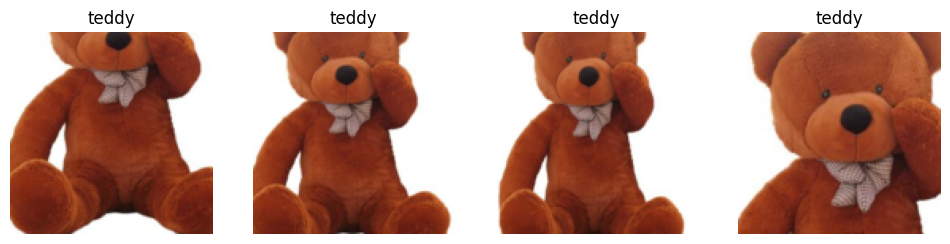

In [3]:
from fastai.data.all import DataBlock, CategoryBlock, RandomSplitter, parent_label
from fastai.vision.all import ImageBlock, RandomResizedCrop, get_image_files, aug_transforms

datablock = DataBlock(
  # Inputs are images, outputs are categories (grizzly, black, teddy).
  blocks=(ImageBlock, CategoryBlock),
  # Recursively extract images based on extension from bears/ folder.
  get_items=get_image_files,
  # Split training and testing with a 80/20 ratio, respectively.
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  # Extract labels from folder name.
  get_y=parent_label,
  # Apply a resized crop transform. Result shown below.
  item_tfms=[RandomResizedCrop(128, min_scale=0.3)],
  # NEW ARGUMENT: Apply common batch transformations.
  # batch_tfms argument is commented since its crashing my Jupyter Notebook
  # local kernel. It runs well on Kaggle/Colab so it seems to be an issue
  # with my personal computer (maybe accessing the GPU, or something internal to the Kernel)...
  # Working example with batch_tfms: https://www.kaggle.com/code/dmoscc/bear-classifier
  # batch_tfms=aug_transforms()
)
dataloaders = datablock.dataloaders(path)

# We used unique=True to have the same image repeated with different versions of this RandomResizedCrop transform.
# This is a specific example of a more general technique, called data augmentation.
dataloaders.show_batch(max_n=4, nrows=1, unique=True)

## Train the model

In [4]:
from fastai.metrics import error_rate
from fastai.vision.all import vision_learner, resnet18


learner = vision_learner(dataloaders, resnet18, metrics=[error_rate])
learner.fine_tune(4)

/Users/oscarrodriguez/src/fastai-course/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oscarrodriguez/src/fastai-course/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from fastai.interpret import ClassificationInterpretation


interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix()

Sometimes it's helpful to identify **where** are the errors occurring (i.e. cases where the loss is largest). That is, cases where the model did a wrong prediction and it was **too confident** about it; and the other end of the spectrum, where the model did a correct prediction with **low certainty**. We can sort the top losses with fastai library using `plot_top_losses(...)` from an `Interpretation` object.

In [ ]:
interpretation.plot_top_losses(5, nrows=1)

As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction. Sometimes is better to train your model before cleaning the data (counterintuitive but it helps...) to identify potential mistakes (wrong classification, non-relevant images, etc.) and clean them up before jumping into the **real** training...

We can use fastai's `ImageClassifierCleaner` to clean classifier learners. This cleaner allows you to change an image category, and whether it should be used for training or testing. The images are displayed sorted by loss in descending order along with menus to select/remove images and relabel them if necessary:

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner


cleaner = ImageClassifierCleaner(learner)
cleaner

ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected for deletion, we would run:

```
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

# Exporting the model

For all learners, the method `.export(...)` exports the architecture, trained parameters (weights), and the `DataLoader` definitions used to train the model. Persisting the original `DataLoader`s used is useful so the model can apply the same transformations that were used during training to a new prediction (`Resize`, etc.). The fastai library only uses the validation set `DataLoader` for inference by default, i.e. data augmentation will not be applied (usually what you want).

In [ ]:
learner.export()

# Testing the exported model

When a model is loaded and used to make predictions, we call it **inference**. fastai learners (and pretty much most ML libs out there) use `.predict(...)` method to make predictions. The method returns the following 3-value tuple:

- The predicted category in the original format
- The index of the predicted category
- The probabilites of each category

The last two are based on the order of categories in the `vocab` of the `DataLoaders`; i.e., the stored list of all possible categories. You can access the original `DataLoaders` used to train the learner (`learner.dls`, and `learner.dls.vocab` for access the categories).

In [ ]:
from fastai.learner import load_learner


path = Path()
loaded_learner = load_learner(path/"export.pkl")
loaded_learner.predict("examples/teddy-1.jpg")